In [1]:
#import librariess
%matplotlib inline
import pandas as pd
import numpy as np
import folium
import json
import matplotlib
from matplotlib import pyplot as plt
import branca.colormap as cm

#path to folder containing data
DATA_FOLDER='data/'
#path to folder containing topojson files
TOPOJSON_FOLDER='topojson/'
#path to maps folder
MAPS_FOLDER='maps/'

## General description
In this homework, we are asked to work with data from two different websites, Eurostat and Amstat. <br>
From these, we need to get unemployment data at the level of European countries and of Swiss cantons. <br>
We are asked to display this data using choropleth maps and bar charts. 

This notebook will be organized as follows:
- Part 1: this part relates to Question 1 of the homework. We display the unemployment rates in european countries on a choropleth map and analyze the results.
- Part 2: this part relates to Question 2 of the homework. 
    - a) We display the unemployment rates as defined by The Swiss Confederation in Swiss cantons on a choropleth map and analyze the results
    - b) We display the unemployment rate redefined to not include people who already have a job and are looking for a new one and analyze the results in contrast with the previous one.
- Part 3: this part relates to Question 3 of the homework.
    - a) We show the difference in unemployment rates between swiss and non-swiss in each canton on a choropleth map and analyze the results
    - b) We show the difference in unemployment rates for swiss and non-swiss in each canton by splitting the data by age groups using bar charts and analyze the results.

## Part 1

From the eurostat website, we get the dataset called "Unemployment rate - annual data" (product code: tipsun20), as it shows the unemployment rate in countries that belong to the European Union by year. We read this data into a dataframe and extract the following two columns:
- country code: it helps us map the data to the information in the Topojson file
- Unemployment rate: the values that we need to show on the map

We display the obtained dataframe.

In [2]:
#path to data file
eurostat_data_path = DATA_FOLDER + 'europe_unemployment.tsv'
#path to topojson file
europe_topo_path=TOPOJSON_FOLDER + 'europe.topojson.json'


#read data into dataframe
eurostat_data=pd.read_csv(eurostat_data_path, sep="\t")
#split first column
eurostat_data[['sex','age', 'unit', 'geo\\time']] = eurostat_data[eurostat_data.columns[0]].str.split(',',expand=True)
#select rows where age is equal to TOTAL for generality
eurostat_data=eurostat_data.loc[eurostat_data['age']=='TOTAL']
#select relevant columns (recent data and location)
recent_eurostat=pd.DataFrame(eurostat_data[['geo\\time', '2016 ']])
#rename columns
recent_eurostat.columns=['Country', 'Unemployment rate']
recent_eurostat.head()

,Country,Unemployment rate
0,AT,6.0
1,BE,7.8
2,BG,7.6
3,CY,13.0
4,CZ,4.0


Since switzerland is not in the EU, it does not appear in the Eurostat dataset. We therefore get a dataset with the unemployment rate for Switzerland from Amstat for the year 2016, to stay consistent with the date of the Eurostat dataset. <br>
It contains, for each canton, the unemployment rate, the number of registered unemployed people, the number of people asking for a job (total), and the number of people asking for a job who already have a job.<br>
We get the dataset in German to match more of the names in the Topojson file of Swiss cantons. <br>
For readability, we reformat the dataset to English. <br>
This same dataset will be used in both Part 1, to get the overall unemployment rate in Switzerland, and part 2, to get the unemployment rates in Switzerland by canton.

In [3]:
switzerland_data_path=DATA_FOLDER + 'DE_swiss_unemployment.txt'
switzerland_data = pd.read_csv(switzerland_data_path)

#reformatting to english for easier manipulation
english_col_names=['Canton', 'Measures', 'Unemployment rate', 'Registered unemployed',
                   'Registered job seekers', 'Not unemployed job seekers']
switzerland_data.columns=english_col_names
switzerland_data.loc[switzerland_data['Canton'] == 'Gesamt' , 'Canton'] = 'Total'
switzerland_data=switzerland_data.drop("Measures", axis=1)
switzerland_data.head()

,Canton,Unemployment rate,Registered unemployed,Registered job seekers,Not unemployed job seekers
0,Zürich,3.7,361007.0,441431.0,80424.0
1,Bern,2.7,183398.0,241011.0,57613.0
2,Luzern,2.1,55221.0,89599.0,34378.0
3,Uri,1.0,2418.0,4361.0,1943.0
4,Schwyz,1.8,18446.0,27475.0,9029.0


From the previous dataset, we add the total unemployment rate (over all cantons) to the Eurostat data with "CH" as country code.

In [4]:
recent_eurostat.loc[recent_eurostat.shape[0]]=['CH',
                                               float(switzerland_data.loc[switzerland_data['Canton'] == 'Total']['Unemployment rate'])]


**For all choropleth maps in this notebook:** <br>
We split the unemployment rate by quantile, as it splits the data into categories of almost equal sizes. <br>
We found that 5 categories represented the unemployment values best.<br>
The categories are therefore defined based on the distribution of the unemployment rates in the dataset. This allows for better comparison of unemployment rates in different countries to each other.

We first define our color palette: we use a gradient of red colors. <br>
We then define a custom color function that associates each color in the color palette to one of the 5 categories of unemployement rate based on the quantiles. We represent any missing data with dark grey. <br>
This function is helpful in this case since a lot of countries that are present in the Topojson file are not present in our dataset.

In [5]:
#gradient of reds
color_palette=['#fee5d9', '#fcae91', '#fb6a4a', '#de2d26','#a50f15']

#custom color function
def my_color_function(data, feature, quantiles, color_palette):
    if(feature['id'] not in data):
         #if value for a country is not in the unemployment data, show dark grey on the map
        return '#929292'
    #else, match each category to corresponding color in color palette
    if(quantiles[0] <= data[feature['id']] < quantiles[1]):
        return color_palette[0]
    if (quantiles[1] <= data[feature['id']] < quantiles[2]):
        return color_palette[1]
    if (quantiles[2] <= data[feature['id']] < quantiles[3]):
        return color_palette[2]
    if (quantiles[3] <= data[feature['id']] < quantiles[4]):
        return color_palette[3]
    if (quantiles[4] <= data[feature['id']] < quantiles[5]):
        return color_palette[4]

Finally, we create a choropleth map of the unemployment rate in the EU + Switzerland. <br>

In [6]:
#set Country as index to reformat data into dict to be passed to color function
unemployment_dict_euro = recent_eurostat.set_index('Country')['Unemployment rate']

#create quantile splits
quantiles_euro=np.floor(pd.qcut(recent_eurostat['Unemployment rate'],5, retbins=True)[1].tolist())

#base map with Europe's coordinates
euro_map = folium.Map(location=[54.5260, 15.2551], tiles='cartodbpositron', zoom_start=3.5)

#add unemployment rate data and use custom color function
folium.TopoJson(
    open(europe_topo_path),
    'objects.europe',
    name='topojson',
    style_function=lambda feature: {
        'fillColor': my_color_function(unemployment_dict_euro, feature, quantiles_euro, color_palette),
        'color': 'black',
        'fillOpacity': 0.8,
        'weight': 1
    }
).add_to(euro_map)

#create and add legend
legend = cm.StepColormap(
     color_palette,
     vmin=quantiles_euro[0], vmax=quantiles_euro[len(quantiles_euro) -1],
     index=quantiles_euro
)

legend.caption='Unemployment rate (%)'
euro_map.add_child(legend)

#export map to html
euro_map.save(MAPS_FOLDER + 'Europe_unemployment.html')


The map is saved in the folder "maps" under the name "Europe_unemployment.html".<br>
For your convenience, you can click on this link to view it: https://rawgit.com/fayezmourad/ada/master/Homework%203/maps/Europe_unemployment.html

### Observations:
On the map, we can see that Switzerland has one of the lowest unemployment rates in Europe. Indeed, if we look at the dataset, we can see that it actually has the lowest unemployment rate among the countries in the dataset. <br>
It is one of only 3 countries that have an unemployment rate lower than 5, along with Germany and Czech republic.

## Part 2-a 
In this part, we display the unemployment rates in Switzerland for each canton. <br>
We use the unemployment rate as is from the downloaded dataset, which means that unemployment rate in this case is defined by the **Swiss Confederation**, and is given by: <br>
**number of job seekers / active population** <br>
To stay consistent with Part 1, we use the same dataset from which we extracted the overall unemployment rate in Switzerland (data for the entire year of 2016). <br>

As a first step, we look for mismatches in the canton names with the provided Topojson file. We find 8 mismatches which we fix manually.

In [7]:
#Fix names that don't match topojson
switzerland_data.loc[switzerland_data['Canton'] == 'Bern' , 'Canton']='Bern/Berne'
switzerland_data.loc[switzerland_data['Canton'] == 'Freiburg' , 'Canton']='Fribourg'
switzerland_data.loc[switzerland_data['Canton'] == 'Graubünden' , 'Canton']='Graubünden/Grigioni'
switzerland_data.loc[switzerland_data['Canton'] == 'Tessin' , 'Canton']='Ticino'
switzerland_data.loc[switzerland_data['Canton'] == 'Waadt' , 'Canton']='Vaud'
switzerland_data.loc[switzerland_data['Canton'] == 'Wallis' , 'Canton']='Valais/Wallis'
switzerland_data.loc[switzerland_data['Canton'] == 'Neuenburg' , 'Canton']='Neuchâtel'
switzerland_data.loc[switzerland_data['Canton'] == 'Genf' , 'Canton']='Genève'

We then plot the unemployment rate values on a choropleth map. We use the same color palette as in part 1, and also go with the quantiles method of splitting the data. <br>
For this map and the subsequent ones, we do not need to use our self-defined color function, as there are no cantons for which we do not have data. We threfore use folium's choropleth() function to create the map, with a predefined color palette.

In [8]:
#take only canton and unemployment rate values from the Switzerland dataset
switzerland_conf_rate=switzerland_data[['Canton', 'Unemployment rate']]
#drop Total row as we are interested in individual cantons only
switzerland_conf_rate = switzerland_conf_rate.loc[switzerland_conf_rate['Canton'] != 'Total']

#read topojson file as json object
swiss_topo_path = TOPOJSON_FOLDER + 'ch-cantons.topojson.json'
swiss_topo = json.loads(open(swiss_topo_path).read())

#split unemployment rate into 5 quantiles
quantiles_swiss_conf=pd.qcut(switzerland_conf_rate['Unemployment rate'],5, retbins=True)[1].tolist()
quantiles_swiss_conf[5]=quantiles_swiss_conf[5] + 0.01

#base map with Switzerland coordinates
swiss_conf_map= folium.Map(location=[46.8182, 8.2275], tiles='cartodbpositron', zoom_start=8)
#create choropleth
swiss_conf_map.choropleth(
    geo_data=swiss_topo,
    topojson='objects.cantons',
    key_on='properties.name',
    name='choropleth',
    data=switzerland_conf_rate,
    columns=['Canton', 'Unemployment rate'],
    fill_color='OrRd',
    fill_opacity=1,
    line_opacity=0.8,
    legend_name='Unemployment Rate (%)',
    threshold_scale=quantiles_swiss_conf
)

#export map to html
swiss_conf_map.save(MAPS_FOLDER + "Switzerland_swiss_confederation_unemployment.html")

The map is saved in the folder "maps" under the name "Switzerland_swiss_confederation_unemployment.html". <br>
For your convenience, you can click on this link to view it: https://rawgit.com/fayezmourad/ada/master/Homework%203/maps/Switzerland_swiss_confederation_unemployment.html

### Observations: 
We can see that the range in which the unemployment rate in Switzerland falls is quite narrow (1%-5.8%) and very low. We notice that the cantons with the highest unemployment rates (3.9%-4.8%) are in a crescent on the west, on the borders of France and Italy.<br>
Central cantons generally have low unemployment rates.

## Part 2-b 
In this part, we display the unemployment rates in Switzerland for each canton, with unemployment rate redefined as: <br>
**number of job seekers currently without a job/ active population** <br>
We use the same dataset as in the previous question, but use different attributes.<br>
The number of job seekers currently without a job is the number of registered unemployed people, which we have in the dataset. We need to divide this by the active population. <br>
We calculate the active population as follows: <br>
**active population = [job seekers (total) / unemployment rate] * 100** <br>
We then calculate the alternative unemployment rate as:<br>
**alternative unemployment rate = registered unemployed / active population** <br>

In [9]:
#calculate alternative unemployment rate as described above
switzerland_data['Alternative unemployment rate'] = switzerland_data['Registered unemployed'] / ((switzerland_data['Registered job seekers'] * 100) / switzerland_data['Unemployment rate']) * 100
#take only canton and alternative unemployment rate values
switzerland_alternative_rate = switzerland_data[['Canton', 'Alternative unemployment rate']]
#drop Total row as we are interested in individual cantons only
switzerland_alternative_rate = switzerland_alternative_rate.loc[switzerland_alternative_rate['Canton'] != 'Total'] 
switzerland_alternative_rate.head()

,Canton,Alternative unemployment rate
0,Zürich,3.025900
1,Bern/Berne,2.054573
2,Luzern,1.294257
3,Uri,0.554460
4,Schwyz,1.208473


Once we have the alternative unemployment rate for each canton, we plot this data on a choropleth map, using the same color scheme as in Part 2-a. 

In [10]:
#split alternative unemployment rate by 5 quantiles
quantiles_alternative=pd.qcut(switzerland_alternative_rate['Alternative unemployment rate'],5, retbins=True)[1].tolist()
quantiles_alternative[5]= quantiles_alternative[5] + 0.01

#base map with Switzerland coordinates
swiss_map_alternative= folium.Map(location=[46.8182, 8.2275], tiles='cartodbpositron', zoom_start=8)
#create choropleth
swiss_map_alternative.choropleth(
    geo_data=swiss_topo,
    topojson='objects.cantons',
    key_on='properties.name',
    name='choropleth',
    data=switzerland_alternative_rate,
    columns=['Canton', 'Alternative unemployment rate'],
    fill_color='OrRd',
    fill_opacity=1,
    line_opacity=0.8,
    legend_name='Alternative unemployment Rate (%)',
    threshold_scale=quantiles_alternative
)

#export map to html
swiss_map_alternative.save(MAPS_FOLDER + "Switzerland_alternative_unemployment.html")


The map is saved in the folder "maps" under the name "Switzerland_alternative_unemployment.html". <br> 
For your convenience, you can click on this link to view it: https://rawgit.com/fayezmourad/ada/master/Homework%203/maps/Switzerland_alternative_unemployment.html

### Observations: 
The alternative unemployment rate is generally lower, which is expected as it disregards a portion of people that were previously considered to be unemployed. <br>
We consider 5 categories in both scenarios. 
The distribution by category with the alternative rate is similar to the original one: the cantons with the highest alternative unemployment rate are the ones in the west. <br>
However, the canton of Valais does not fall in the highest category of unemployment rate anymore. <br>
Moreover,  the canton of Zurich now falls in the highest unemployment rate category, when it didnt with the Swiss Confederation definition of unemployment rate.  <br>
The central cantons still have a low unemployment rate.

## Part 3-a

In this part, we get a new dataset from Amstat which includes the unemployment rates for each canton. split by swiss/non-swiss. (also for the year 2016 for consistency)<br>
We preprocess this data by translating the German column names to English and by matching the cantons with their names in the Topojson file.

In [11]:
#read and preprocess data
swiss_data_nationality = pd.read_csv(DATA_FOLDER + 'DE_swiss_nationality.txt')
swiss_data_nationality
#reformat to english
english_col_names=['Canton', 'Nationality', 'Unemployment rate']
swiss_data_nationality.columns=english_col_names
swiss_data_nationality.loc[swiss_data_nationality['Nationality'] == 'Ausländer', 'Nationality'] = 'Foreigner'
swiss_data_nationality.loc[swiss_data_nationality['Nationality'] == 'Schweizer', 'Nationality'] = 'Swiss'

#remove 'Total row'
swiss_data_nationality=swiss_data_nationality.loc[swiss_data_nationality['Canton'] != 'Gesamt']

#Fix names that don't match topojson
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Bern' , 'Canton']='Bern/Berne'
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Freiburg' , 'Canton']='Fribourg'
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Graubünden' , 'Canton']='Graubünden/Grigioni'
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Tessin' , 'Canton']='Ticino'
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Waadt' , 'Canton']='Vaud'
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Wallis' , 'Canton']='Valais/Wallis'
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Neuenburg' , 'Canton']='Neuchâtel'
swiss_data_nationality.loc[swiss_data_nationality['Canton'] == 'Genf' , 'Canton']='Genève'

swiss_data_nationality.head(6)

,Canton,Nationality,Unemployment rate
0,Zürich,Foreigner,6.0
1,Zürich,Swiss,2.8
2,Bern/Berne,Foreigner,6.5
3,Bern/Berne,Swiss,2.0
4,Luzern,Foreigner,4.7
5,Luzern,Swiss,1.5


The goal here is to show the difference in unemployment rate between foreigners and swiss citizen. <br>
To do so on one map, we calculate, for each canton, the difference between the unemployment rate for foreigners and the unemployment rate for swiss people.

In [12]:
#split the data by Swiss/Foreigner (same order of cantons)
unemployment_rate_swiss=swiss_data_nationality.loc[swiss_data_nationality['Nationality'] == 'Swiss'].set_index('Canton')
unemployment_rate_foreigner=swiss_data_nationality.loc[swiss_data_nationality['Nationality'] == 'Foreigner'].set_index('Canton')

#dataframe with difference in unemployment rate between foreigners and swiss
unemployment_rate_difference=pd.DataFrame(unemployment_rate_foreigner['Unemployment rate'] - unemployment_rate_swiss['Unemployment rate'])
unemployment_rate_difference.columns=['Difference in unemployment rate']
unemployment_rate_difference=unemployment_rate_difference.reset_index()
unemployment_rate_difference.head(3)

,Canton,Difference in unemployment rate
0,Zürich,3.2
1,Bern/Berne,4.5
2,Luzern,3.2


We then plot this difference on one choropleth map. The regions which have the highest difference in unemployment rate have the highest discrepancy between foreigners and swiss when it comes to unemployment rate.

In [13]:
#split difference in unemployment rate by 5 quantiles
quantiles_difference=pd.qcut(unemployment_rate_difference['Difference in unemployment rate'],5, retbins=True)[1].tolist()
quantiles_difference[5] = quantiles_difference[5]  + 0.01

#base map with Switzerland coordinates
swiss_map_diff= folium.Map(location=[46.8182, 8.2275], tiles='cartodbpositron', zoom_start=8)

swiss_map_diff.choropleth(
    geo_data=swiss_topo,
    topojson='objects.cantons',
    key_on='properties.name',
    name='choropleth',
    data=unemployment_rate_difference,
    columns=['Canton', 'Difference in unemployment rate'],
    fill_color='OrRd',
    fill_opacity=1,
    line_opacity=0.8,
    legend_name='Difference in unemployment rate between foreigners and swiss(%)',
    threshold_scale=quantiles_difference
)

#export map as html
swiss_map_diff.save(MAPS_FOLDER + "Switzerland_unemployment_difference.html")

The map is saved in the folder "maps" under the name "Switzerland_unemployment_difference.html". <br>
For your convenience, you can click on this link to view it: https://rawgit.com/fayezmourad/ada/master/Homework%203/maps/Switzerland_unemployment_difference.html

### Observations:
We notice that the largest discrepancies in unemployment rate between foreigners and swiss are found in the following cantons: Bern, Jura, Neuchatel, Zurich, Valais, and Schaffhausen. <br>
The lowest discrepancies in unemployment rate between foreigners and swiss are found in the following cantons: Obwalden, Nidwalden and Zug.
Geographically, there is no real pattern when it comes to how the difference in unemployment rates between foreigners and swiss are spread over the cantons.<br>
However, these discrepancies seem to be higher in cantons that include big cities, such as Bern and Zurich, where the work market is big and competitive. This might explain why more foreigners are unemployed in these cantons.

## Part 3-b

In this part, we refine our analysis by further splitting the data into age categories. <br>
We get a new dataset from Amstat, which contais the number of job seekers for both foreigners and swiss, split by age category. We choose the number of job seekers as a metric in this case since it is not possible to get the unemployment rate from the Amstat website using two different criteria (age and nationality in this case).<br>
We drop unwanted columns, and translate to english for clarity.

In [14]:
swiss_nationality_age=pd.read_csv(DATA_FOLDER + 'DE_swiss_nationality_age.txt', sep="\t")

#drop unwated columns
swiss_nationality_age=swiss_nationality_age.drop(swiss_nationality_age.columns[[2,4]], axis=1)

#reformat to english
english_col_names=['Canton', 'Nationality', 'Age group', 'Job seekers']

swiss_nationality_age.columns=english_col_names
swiss_nationality_age['Age group'] = swiss_nationality_age['Age group'].str.replace('Jahre', 'years')
swiss_nationality_age['Age group']= swiss_nationality_age['Age group'].str.replace('und mehr', 'and more')
swiss_nationality_age.loc[swiss_nationality_age['Nationality'] == 'Ausländer', 'Nationality'] = 'Foreigner'
swiss_nationality_age.loc[swiss_nationality_age['Nationality'] == 'Schweizer', 'Nationality'] = 'Swiss'
swiss_nationality_age.loc[swiss_nationality_age['Nationality'] == 'Gesamt', 'Nationality'] = 'Total'
swiss_nationality_age.head(18)

,Canton,Nationality,Age group,Job seekers
0,Zürich,Foreigner,15-24 years,1178
1,Zürich,Foreigner,25-49 years,11188
2,Zürich,Foreigner,50 and more,3018
3,Zürich,Foreigner,NaN,15384
4,Zürich,Swiss,15-24 years,2671
5,Zürich,Swiss,25-49 years,10083
6,Zürich,Swiss,50 and more,6018
7,Zürich,Swiss,NaN,18772
8,Zürich,Total,NaN,34156
9,Bern,Foreigner,15-24 years,722


Since there is no way to obtain the the active population for each age group AND each category of nationality (foreigner/swiss) at the same time from the Amstat website, we approach this problem in a different way.<br>
To get an estimate of the unemployment rate, we get the percentage of the active population for each age category. We also do the same for each nationality category (swiss/foreigner).<br>
In adddition, we get the total active population by canton, and we infer and estimate of the active population for each combination of nationality and age categories from te percentages and total active population.<br>
We then divide the number of job seekers by the active population for each combination of categories.<br>

To be able to do so, we first get a dataset from Amstat which contains the unemployment rate and number of job seekers per age category for each canton.

In [15]:
swiss_age_groups=pd.read_csv(DATA_FOLDER + 'DE_swiss_age.txt', sep="\t")
swiss_age_groups

#drop unwated columns
swiss_age_groups=swiss_age_groups.drop(swiss_age_groups.columns[[1,3]], axis=1)
swiss_age_groups
# #reformat to english
english_col_names=['Canton', 'Age group', 'Unemployment rate', 'Job seekers']

swiss_age_groups.columns=english_col_names
swiss_age_groups['Age group'] = swiss_age_groups['Age group'].str.replace('Jahre', 'years')
swiss_age_groups['Age group']= swiss_age_groups['Age group'].str.replace('und mehr', 'and more')

swiss_age_groups.head(9)

,Canton,Age group,Unemployment rate,Job seekers
0,Zürich,15-24 years,3.7,3849.0
1,Zürich,25-49 years,3.4,21271.0
2,Zürich,50 and more,2.9,9036.0
3,Bern,15-24 years,2.8,2405.0
4,Bern,25-49 years,2.5,10493.0
5,Bern,50 and more,2.2,5487.0
6,Luzern,15-24 years,2.1,897.0
7,Luzern,25-49 years,1.7,3761.0
8,Luzern,50 and more,1.6,2098.0


From this, we can infer the active population size for each age group in every canton, as: <br>
**(job seekers / unemployment rate) * 100 **

In [16]:
swiss_age_groups['Active population'] = np.round((swiss_age_groups['Job seekers'] / swiss_age_groups['Unemployment rate']) *100)
swiss_age_groups.head(9)

,Canton,Age group,Unemployment rate,Job seekers,Active population
0,Zürich,15-24 years,3.7,3849.0,104027.0
1,Zürich,25-49 years,3.4,21271.0,625618.0
2,Zürich,50 and more,2.9,9036.0,311586.0
3,Bern,15-24 years,2.8,2405.0,85893.0
4,Bern,25-49 years,2.5,10493.0,419720.0
5,Bern,50 and more,2.2,5487.0,249409.0
6,Luzern,15-24 years,2.1,897.0,42714.0
7,Luzern,25-49 years,1.7,3761.0,221235.0
8,Luzern,50 and more,1.6,2098.0,131125.0


We now get the percentage of the active population in each canton or every age category.

In [17]:
#get total active population per canton
grouped_age_by_canton=swiss_age_groups.groupby('Canton')
total_active_population_per_canton = grouped_age_by_canton.agg(np.sum)['Active population'].reset_index()
total_active_population_per_canton.columns=['Canton', 'Total active population']
total_active_population_per_canton.head(10)

#get percentage of the active population per canton for each age category
merged_age=swiss_age_groups.merge(total_active_population_per_canton, on="Canton")
merged_age['Percentage of active population']  = merged_age['Active population'] / merged_age['Total active population'] * 100

swiss_age_groups_percentage=merged_age[['Canton', 'Age group', 'Percentage of active population']]
swiss_age_groups_percentage = swiss_age_groups_percentage.rename(index=str, columns={'Percentage of active population': 'Percentage of active population by age'})
swiss_age_groups_percentage.head(9)

,Canton,Age group,Percentage of active population by age
0,Zürich,15-24 years,9.990771
1,Zürich,25-49 years,60.084458
2,Zürich,50 and more,29.924772
3,Bern,15-24 years,11.376225
4,Bern,25-49 years,55.590433
5,Bern,50 and more,33.033342
6,Luzern,15-24 years,10.811645
7,Luzern,25-49 years,55.998370
8,Luzern,50 and more,33.189985


We also get percentage of the active population for each nationality category (swiss/foreigner) in each canton in the same manner.

In [18]:
swiss_nationality_groups=pd.read_csv(DATA_FOLDER + 'DE_swiss_nationality_rate_number.txt', sep="\t")
swiss_nationality_groups

# #drop unwated columns
swiss_nationality_groups=swiss_nationality_groups.drop(swiss_nationality_groups.columns[2], axis=1)
swiss_nationality_groups

#reformat to english
english_col_names=['Canton', 'Nationality', 'Unemployment rate', 'Job seekers']
swiss_nationality_groups.columns=english_col_names
swiss_nationality_groups.loc[swiss_nationality_groups['Nationality'] == 'Ausländer', 'Nationality'] = 'Foreigner'
swiss_nationality_groups.loc[swiss_nationality_groups['Nationality'] == 'Schweizer', 'Nationality'] = 'Swiss'

swiss_nationality_groups['Active population'] = np.round((swiss_nationality_groups['Job seekers'] / swiss_nationality_groups['Unemployment rate']) *100)

#get percentage of the active population per canton for each nationality category
merged_nationality=swiss_nationality_groups.merge(total_active_population_per_canton, on="Canton")
merged_nationality['Percentage of active population']  = merged_nationality['Active population'] / merged_nationality['Total active population'] * 100

swiss_nationality_groups_percentage=merged_nationality[['Canton', 'Nationality', 'Percentage of active population']]
swiss_nationality_groups_percentage = swiss_nationality_groups_percentage.rename(index=str, columns={'Percentage of active population' :'Percentage of active population by nationality'})
swiss_nationality_groups_percentage.head(9)

,Canton,Nationality,Percentage of active population by nationality
0,Zürich,Foreigner,27.877003
1,Zürich,Swiss,72.114641
2,Bern,Foreigner,16.517267
3,Bern,Swiss,84.809847
4,Luzern,Foreigner,18.834446
5,Luzern,Swiss,75.039613
6,Uri,Foreigner,13.448044
7,Uri,Swiss,68.978253
8,Schwyz,Foreigner,23.027956


We merge these percentages and the total active population for each canton with the dataframe that contains the number of job seekers per nationality and age groups. <br>
Assuming an equal distribution of age groups between foreigners and swiss, we can calculate a rough estimate of the total active population for each nationality group (foreigner/swiss) and age group combination. 

In [19]:
#merging percentages to dataset
age_nationality_with_percentages= (swiss_nationality_age
                                   .merge(swiss_nationality_groups_percentage, on=['Canton' , 'Nationality'])
                                   .merge(swiss_age_groups_percentage, on=['Canton', 'Age group'])
                                   .merge(total_active_population_per_canton, on=['Canton']))
age_nationality_with_percentages = age_nationality_with_percentages.rename(index=str, columns={'Total active population': 'Total active population in canton'})
age_nationality_with_percentages.head(18)

,Canton,Nationality,Age group,Job seekers,Percentage of active population by nationality,Percentage of active population by age,Total active population in canton
0,Zürich,Foreigner,15-24 years,1178,27.877003,9.990771,1041231.0
1,Zürich,Swiss,15-24 years,2671,72.114641,9.990771,1041231.0
2,Zürich,Foreigner,25-49 years,11188,27.877003,60.084458,1041231.0
3,Zürich,Swiss,25-49 years,10083,72.114641,60.084458,1041231.0
4,Zürich,Foreigner,50 and more,3018,27.877003,29.924772,1041231.0
5,Zürich,Swiss,50 and more,6018,72.114641,29.924772,1041231.0
6,Bern,Foreigner,15-24 years,722,16.517267,11.376225,755022.0
7,Bern,Swiss,15-24 years,1683,84.809847,11.376225,755022.0
8,Bern,Foreigner,25-49 years,4679,16.517267,55.590433,755022.0
9,Bern,Swiss,25-49 years,5814,84.809847,55.590433,755022.0


We calculate the active population for each combination of nationality and age group with the following formula:  <br>
** total active population in canton  x  (percentage of active pop. by nationality/100)  x  (percentage of active pop. by age/100) **

In [20]:
age_nationality_with_percentages['Active population'] = np.round(age_nationality_with_percentages['Total active population in canton']
                                                         * (age_nationality_with_percentages['Percentage of active population by nationality']/100)
                                                         * (age_nationality_with_percentages['Percentage of active population by age']/100))
age_nationality_with_percentages.head(18)

,Canton,Nationality,Age group,Job seekers,Percentage of active population by nationality,Percentage of active population by age,Total active population in canton,Active population
0,Zürich,Foreigner,15-24 years,1178,27.877003,9.990771,1041231.0,29000.0
1,Zürich,Swiss,15-24 years,2671,72.114641,9.990771,1041231.0,75019.0
2,Zürich,Foreigner,25-49 years,11188,27.877003,60.084458,1041231.0,174404.0
3,Zürich,Swiss,25-49 years,10083,72.114641,60.084458,1041231.0,451162.0
4,Zürich,Foreigner,50 and more,3018,27.877003,29.924772,1041231.0,86861.0
5,Zürich,Swiss,50 and more,6018,72.114641,29.924772,1041231.0,224699.0
6,Bern,Foreigner,15-24 years,722,16.517267,11.376225,755022.0,14187.0
7,Bern,Swiss,15-24 years,1683,84.809847,11.376225,755022.0,72846.0
8,Bern,Foreigner,25-49 years,4679,16.517267,55.590433,755022.0,69326.0
9,Bern,Swiss,25-49 years,5814,84.809847,55.590433,755022.0,355964.0


We can now get an estimate of the unemployment rate for eah combination of categories.

In [21]:
age_nationality_with_percentages['Unemployment rate estimate'] = (age_nationality_with_percentages['Job seekers']
                                                                 /age_nationality_with_percentages['Active population']
                                                                 *100)
age_nationality_with_percentages.head(18)

,Canton,Nationality,Age group,Job seekers,Percentage of active population by nationality,Percentage of active population by age,Total active population in canton,Active population,Unemployment rate estimate
0,Zürich,Foreigner,15-24 years,1178,27.877003,9.990771,1041231.0,29000.0,4.062069
1,Zürich,Swiss,15-24 years,2671,72.114641,9.990771,1041231.0,75019.0,3.560431
2,Zürich,Foreigner,25-49 years,11188,27.877003,60.084458,1041231.0,174404.0,6.414990
3,Zürich,Swiss,25-49 years,10083,72.114641,60.084458,1041231.0,451162.0,2.234896
4,Zürich,Foreigner,50 and more,3018,27.877003,29.924772,1041231.0,86861.0,3.474517
5,Zürich,Swiss,50 and more,6018,72.114641,29.924772,1041231.0,224699.0,2.678250
6,Bern,Foreigner,15-24 years,722,16.517267,11.376225,755022.0,14187.0,5.089166
7,Bern,Swiss,15-24 years,1683,84.809847,11.376225,755022.0,72846.0,2.310353
8,Bern,Foreigner,25-49 years,4679,16.517267,55.590433,755022.0,69326.0,6.749272
9,Bern,Swiss,25-49 years,5814,84.809847,55.590433,755022.0,355964.0,1.633311


### Important note:
This calculation of the unemployment rate is not exactly accurate. This is because it assumes that the population is split into age groups in the same way for foreigners and swiss, which is most probably not the case in reality. <br>
This is why the calculated rate is just an estimate of the unemployment rate.

We now want to plot these unemployment rates on a bar chart. <br>
We prepare the dataframe for plotting and use the seaborn library to plot the data.

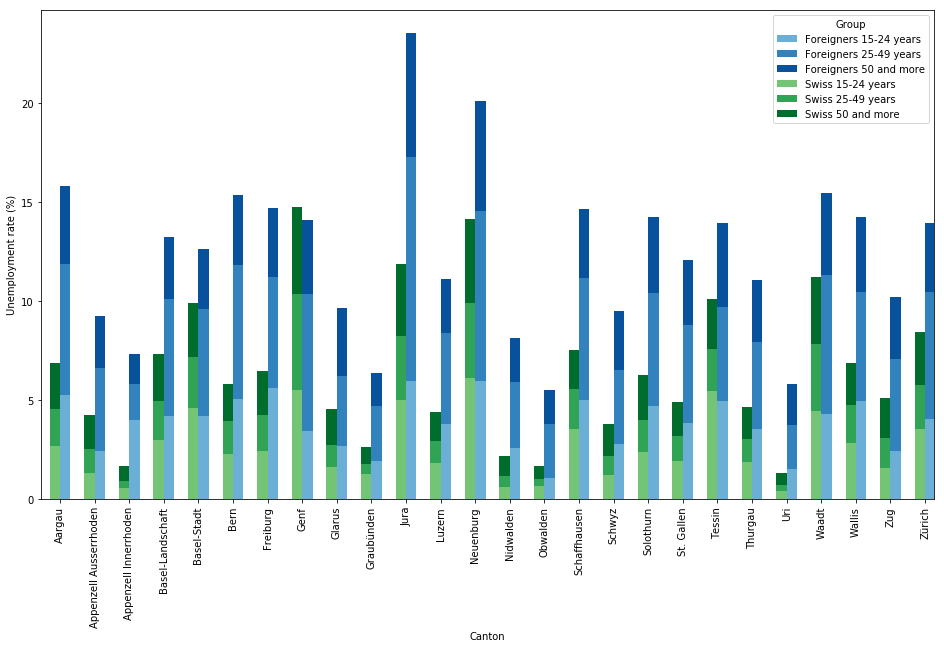

In [22]:
#we keep only wanted columns
unemployment_nationality_age=age_nationality_with_percentages[['Canton', 'Nationality', 'Age group', 
                                                               'Unemployment rate estimate']]
unemployment_nationality_age
#remove Total row for canton
unemployment_nationality_age = unemployment_nationality_age[unemployment_nationality_age['Canton'] != 'Gesamt']

#prepare large plotting canvas
fig, ax = plt.subplots(figsize=(16, 9))

#dataframe for foreigners
unemployment_foreigners=(unemployment_nationality_age
                         .loc[unemployment_nationality_age['Nationality'] == 'Foreigner']
                         .drop('Nationality', axis=1))
unemployment_foreigners.rename(index=str, columns={'Age group': 'Foreigner age groups'}, inplace=True)
#pivot to have each age category as column
unemployment_foreigners=(unemployment_foreigners
                         .pivot(index='Canton', columns='Foreigner age groups', values='Unemployment rate estimate'))
#rename for legend clarity
unemployment_foreigners.rename(index=str, columns={'15-24 years':  'Foreigners 15-24 years',
                                                    '25-49 years': 'Foreigners 25-49 years',
                                                    '50 and more': 'Foreigners 50 and more'}, inplace=True)
#dataframe for swiss
unemployment_swiss=(unemployment_nationality_age
                         .loc[unemployment_nationality_age['Nationality'] == 'Swiss']
                         .drop('Nationality', axis=1))
unemployment_swiss.rename(index=str, columns={'Age group': 'Group'}, inplace=True)
#pivot to have each age category as column
unemployment_swiss=(unemployment_swiss
                         .pivot(index='Canton', columns='Group', values='Unemployment rate estimate'))
unemployment_swiss.rename(index=str, columns={'15-24 years': 'Swiss 15-24 years',
                                              '25-49 years': 'Swiss 25-49 years',
                                              '50 and more': 'Swiss 50 and more'}, inplace=True)

bar_foreigners=unemployment_foreigners.plot.bar(stacked=True, width=0.3, 
                                                ax=ax, position=0, color=['#6baed6','#3182bd','#08519c'])

bar_swiss=unemployment_swiss.plot.bar(stacked=True, width=0.3, 
                                      ax=ax, position=1, color=['#74c476','#31a354', '#006d2c'])
bar_swiss.set_ylabel('Unemployment rate (%)')

### Observations:
We can see that in most cases, for foreigners, the unemployment rate is highest for the age group 25-49, whereas for the swiss, the unemployment rate in most cases is highest for the age group 15-24. <br>
We also notice that overall,  the unemployment rate is higher for foreigners, which is not surprising since we had see this result in a previous question.

